In [266]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *

from data_utils import *
from models import *
from learn_utils import *

In [268]:
torch.cuda.set_device(7)

### data

In [269]:
data_dict.keys()

dict_keys(['notl_brain_mr', 'notl_brain_ct', 'atlas_brain_mr', 'notl_ventricle_mr', 'notl_ventricle_ct', 'atlas_ventricle_mr'])

In [518]:
data_name = 'notl_ventricle_ct'
f = data_dict[data_name]
train_paths, valid_paths, test1_paths, test2_paths = f()

In [519]:
train_ds = MRI_3D_Dataset(*train_paths)
valid_ds = MRI_3D_Dataset(*valid_paths)
test1_ds = MRI_3D_Dataset(*test1_paths) if test1_paths else None
test2_ds = MRI_3D_Dataset(*test2_paths) if test2_paths else None

In [520]:
bs = 1
data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=bs)
test1_dl = DeviceDataLoader(DataLoader(test1_ds, batch_size=bs), device=data.device) if test1_ds else None
test2_dl = DeviceDataLoader(DataLoader(test2_ds, batch_size=bs), device=data.device) if test2_ds else None

### model

In [521]:
bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)
gnorm_types = (nn.GroupNorm,)
insnorm_types = (nn.InstanceNorm1d, nn.InstanceNorm2d, nn.InstanceNorm3d)
norm_types = bn_types + gnorm_types + insnorm_types

def cond_init(m:nn.Module, init_func:LayerFunc):
    "Initialize the non-batchnorm layers of `m` with `init_func`."
    if (not isinstance(m, norm_types)) and (not isinstance(m, nn.PReLU)) and requires_grad(m): 
        init_default(m, init_func)

In [616]:
kaiming_init = True
model_name = 'baseline11'
f = experiment_model_dict[model_name]; m = f()
if kaiming_init: apply_leaf(m, partial(cond_init, init_func= nn.init.kaiming_normal_))

### learn

In [617]:
loss_func = 'dice'
model_dir = 'tl_ventricle_ct_models'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();

### evaluate

In [618]:
import data_utils

In [619]:
sorted((learn.path/learn.model_dir).ls(), key=lambda o:int(o.stem.split('_')[-1]))

[PosixPath('tl_ventricle_ct_models/best_of_TL_Ventricle_CT_Baseline_1.pth'),
 PosixPath('tl_ventricle_ct_models/best_of_TL_Ventricle_CT_Baseline_2.pth'),
 PosixPath('tl_ventricle_ct_models/best_of_TL_Ventricle_CT_Baseline_3.pth'),
 PosixPath('tl_ventricle_ct_models/best_of_TL_Ventricle_CT_Baseline_4.pth'),
 PosixPath('tl_ventricle_ct_models/best_of_TL_Ventricle_CT_Baseline_5.pth'),
 PosixPath('tl_ventricle_ct_models/best_of_TL_Ventricle_CT_Baseline_6.pth'),
 PosixPath('tl_ventricle_ct_models/best_of_TL_Ventricle_CT_Baseline_7.pth'),
 PosixPath('tl_ventricle_ct_models/best_of_TL_Ventricle_CT_Baseline_9.pth'),
 PosixPath('tl_ventricle_ct_models/best_of_TL_Ventricle_CT_Baseline_10.pth'),
 PosixPath('tl_ventricle_ct_models/best_of_TL_Ventricle_CT_Baseline_11.pth')]

In [620]:
learn.load('best_of_TL_Ventricle_CT_Baseline_11');

In [621]:
learn.validate(learn.data.valid_dl)

[0.19636743, tensor(0.8037)]

In [622]:
learn.to_fp32();

In [623]:
if test1_dl: print(learn.validate(test1_dl))

[0.19951624, tensor(0.8005)]


In [624]:
if test2_dl: print(learn.validate(test2_dl))

[0.2646602, tensor(0.7354)]


### debug

In [111]:
def stats(t): return (t.mean(), t.std())

for n, p in learn.model.named_parameters():pass

In [113]:
n, p

('seg_final.c2.bias', Parameter containing:
 tensor([-1.0547], device='cuda:7', requires_grad=True))

### logs

In [114]:
path = Path("logs/"); path.ls()

[PosixPath('logs/notl_brain_ct_models'),
 PosixPath('logs/notl_brain_mr_models'),
 PosixPath('logs/atlas_brain_mr_models')]

In [115]:
path = Path("logs/atlas_brain_mr_models"); path.ls()

[PosixPath('logs/atlas_brain_mr_models/ATLAS_Brain_MR_Baseline_8.csv'),
 PosixPath('logs/atlas_brain_mr_models/ATLAS_Brain_MR_Baseline_7.csv'),
 PosixPath('logs/atlas_brain_mr_models/ATLAS_Brain_MR_Baseline_4.csv'),
 PosixPath('logs/atlas_brain_mr_models/ATLAS_Brain_MR_Baseline_1.csv'),
 PosixPath('logs/atlas_brain_mr_models/ATLAS_Brain_MR_Baseline_6.csv'),
 PosixPath('logs/atlas_brain_mr_models/ATLAS_Brain_MR_Baseline_2.csv'),
 PosixPath('logs/atlas_brain_mr_models/ATLAS_Brain_MR_Baseline_3.csv'),
 PosixPath('logs/atlas_brain_mr_models/ATLAS_Brain_MR_Baseline_5.csv'),
 PosixPath('logs/atlas_brain_mr_models/ATLAS_Brain_MR_Baseline_10.csv'),
 PosixPath('logs/atlas_brain_mr_models/ATLAS_Brain_MR_Baseline_11.csv'),
 PosixPath('logs/atlas_brain_mr_models/ATLAS_Brain_MR_Baseline_9.csv')]

In [116]:
log_df = pd.read_csv(path/'ATLAS_Brain_MR_Baseline_11.csv')

In [119]:
log_df

,epoch,train_loss,valid_loss,dice_score
0,0,0.067217,0.039492,0.932314
1,1,0.044604,0.027971,0.934879
2,2,0.038939,0.027469,0.933695
3,3,0.024259,0.022256,0.942935
4,4,0.044134,0.018329,0.950114
5,5,0.030373,0.016467,0.945641
6,6,0.018827,0.016503,0.943256
7,7,0.018283,0.013724,0.956241
8,8,NaN,NaN,0.000000


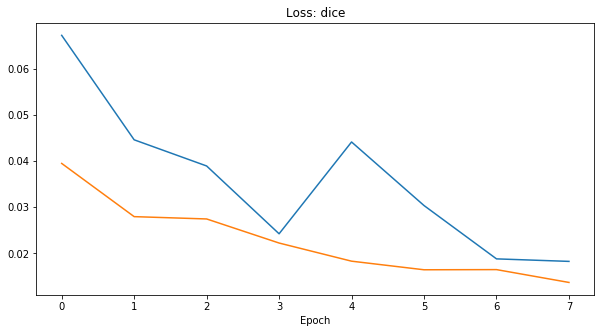

In [117]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title(f'Loss: {loss_func}')
ax.set_xlabel("Epoch")
ax.plot(log_df['train_loss'])
ax.plot(log_df['valid_loss']);

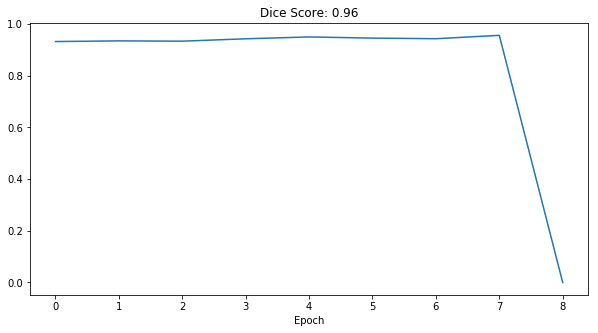

In [118]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title(f"Dice Score: {np.round(log_df['dice_score'].max(), 2)}")
ax.set_xlabel("Epoch")
plt.plot(log_df['dice_score']);

### Visualize

In [83]:
def to_int8(a): return a.astype(np.uint8)

In [65]:
data1 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test1_ds, bs=3)
data2 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test2_ds, bs=3)

In [125]:
train_fnames = data1.train_ds.img_fnames
valid_fnames = data1.valid_ds.img_fnames
test1_fnames = data1.test_ds.img_fnames
test2_fnames = data1.test_ds.img_fnames

In [128]:
len(train_fnames), len(valid_fnames), len(test1_fnames), len(test2_fnames)

(112, 15, 15, 15)

In [118]:
train_dl = data1.train_dl.new(shuffle=False)
valid_dl = data1.valid_dl.new(shuffle=False)
test1_dl = data1.test_dl.new(shuffle=False)
test2_dl = data2.test_dl.new(shuffle=False)

In [70]:
learn.to_fp16();

In [1]:
# # training
# images, preds, masks = get_img_pred_masks(learn, train_dl)

# # validation
# images, preds, masks = get_img_pred_masks(learn, valid_dl)

# # test1
# images, preds, masks = get_img_pred_masks(learn, test1_dl)

# # test2
# images, preds, masks = get_img_pred_masks(learn, test2_dl)

### Compare Deep Learning with Atlas

Skull strip train, valid, test1 and test2

- Compare with atlas masks
- RuntimeError: _th_cat is not implemented for type torch.HalfTensor
- Save to data_path/**/skull_stripped_v2

In [15]:
parent_dataset = 'MR_Dataset_Atlas'

In [16]:
def get_predictions(model, dl):
    res = []
    model.eval()
    with torch.no_grad():
        for xb,yb in progress_bar(dl):
            out = model(xb)
            out = to_detach(out)
            res.append(out)
    res = torch.cat([o.float() for o in res]) # converts to fp32 cat doesn't work with fp16
    return res

In [17]:
data1 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test1_ds, bs=2)
data1.add_tfm(batch_to_half)
data2 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test2_ds, bs=2)
data2.add_tfm(batch_to_half)

In [18]:
train_dl = data1.train_dl.new(shuffle=False)
valid_dl = data1.valid_dl.new(shuffle=False)
test1_dl = data1.test_dl.new(shuffle=False) if test1_ds else None
test2_dl = data2.test_dl.new(shuffle=False) if test2_ds else None

In [19]:
# my data copy path
data_path = Path('../../data/Segmentation_Dataset/')

In [20]:
train_fnames = data1.train_ds.img_fnames
valid_fnames = data1.valid_ds.img_fnames
test1_fnames = data1.test_ds.img_fnames if test1_ds else None 
test2_fnames = data2.test_ds.img_fnames if test2_ds else None

In [107]:
learn.to_fp16();

In [43]:
# model predictions
train_preds = get_predictions(learn.model, train_dl)
valid_preds = get_predictions(learn.model, valid_dl)
test1_preds = get_predictions(learn.model, test1_dl) if test1_ds else None
test2_preds = get_predictions(learn.model, test2_dl) if test2_ds else None

In [44]:
train_preds.shape, valid_preds.shape, test1_preds.shape, test2_preds.shape

(torch.Size([106, 1, 128, 256, 256]),
 torch.Size([26, 1, 128, 256, 256]),
 torch.Size([9, 1, 128, 256, 256]),
 torch.Size([18, 1, 128, 256, 256]))

In [45]:
def collect_masks(dl): return torch.cat([to_cpu(yb) for _, yb in dl])

In [46]:
# human annotated masks
train_masks = collect_masks(train_dl)
valid_masks = collect_masks(valid_dl)
test1_masks = collect_masks(test1_dl) if test1_ds else None
test2_masks = collect_masks(test2_dl) if test2_ds else None

In [47]:
for masks in (train_masks, valid_masks, test1_masks, test2_masks):
    masks.unsqueeze_(1)

In [48]:
train_masks.shape, valid_masks.shape, test1_masks.shape, test2_masks.shape

(torch.Size([106, 1, 128, 256, 256]),
 torch.Size([26, 1, 128, 256, 256]),
 torch.Size([9, 1, 128, 256, 256]),
 torch.Size([18, 1, 128, 256, 256]))

In [49]:
def load_atlas(path, fnames):
    return torch.cat([torch.tensor(np.load(path/fn.name))[None] for fn in fnames])

In [50]:
train_atlas_path = (data_path/f'{parent_dataset}/train/brain_atlas')
valid_atlas_path = (data_path/f'{parent_dataset}/validation/brain_atlas')
test1_atlas_path = (data_path/f'{parent_dataset}/test1/brain_atlas')
test2_atlas_path = (data_path/f'{parent_dataset}/test2/brain_atlas')

In [51]:
# machine annotated masks
train_atlas = load_atlas(train_atlas_path, train_fnames)
valid_atlas = load_atlas(valid_atlas_path, valid_fnames)
test1_atlas = load_atlas(test1_atlas_path, test1_fnames)
test2_atlas = load_atlas(test2_atlas_path, test2_fnames)

In [52]:
for masks in (train_atlas, valid_atlas, test1_atlas, test2_atlas):
    masks.unsqueeze_(1)

In [53]:
train_atlas.shape, valid_atlas.shape, test1_atlas.shape, test2_atlas.shape

(torch.Size([107, 1, 128, 256, 256]),
 torch.Size([26, 1, 128, 256, 256]),
 torch.Size([9, 1, 128, 256, 256]),
 torch.Size([18, 1, 128, 256, 256]))

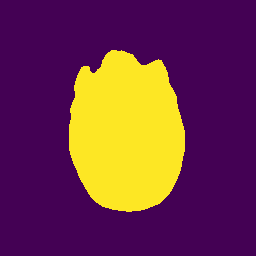

In [71]:
image_no=5
slice_no=64
ImageSegment(train_preds[image_no, :, slice_no] > 0)

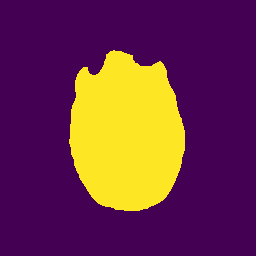

In [72]:
image_no=5
slice_no=64
ImageSegment(train_masks[image_no, :, slice_no] > 0)

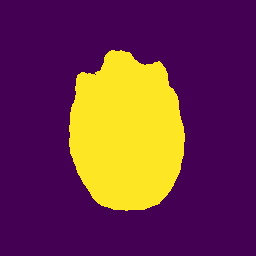

In [73]:
image_no=5
slice_no=64
ImageSegment(train_atlas[image_no, :, slice_no] > 0)

In [66]:
# deep learning performance
train_preds_score = dice_score(train_preds, train_masks)
valid_preds_score = dice_score(valid_preds, valid_masks)
test1_preds_score = dice_score(test1_preds, test1_masks)
test2_preds_score = dice_score(test2_preds, test2_masks)

In [67]:
train_preds_score, valid_preds_score, test1_preds_score, test2_preds_score

(tensor(0.9823), tensor(0.9822), tensor(0.9822), tensor(0.9772))

In [69]:
# atlas performance
train_atlas_score = dice_score(train_atlas, train_masks)
valid_atlas_score = dice_score(valid_atlas, valid_masks)
test1_atlas_score = dice_score(test1_atlas, test1_masks)
test2_atlas_score = dice_score(test2_atlas, test2_masks)

In [70]:
train_atlas_score, valid_atlas_score, test1_atlas_score, test2_atlas_score

(tensor(0.9847), tensor(0.9860), tensor(0.9853), tensor(0.9790))

### Skull Stripping v2

- Human annotated brain masks will be used where possible
- "First, we normalize each modality of each patient independently by subtracting the mean and dividing by the standard deviation of the brain region. We then clip the resulting images at [−5, 5] to remove outliers and subsequently rescale to [0, 1], with the non-brain region being set to 0."

In [21]:
import seaborn as sns

In [22]:
parent_dataset = 'MR_Dataset_Atlas'

In [23]:
os.makedirs(data_path/f'{parent_dataset}/train/skull_stripped_v2', exist_ok=True)
os.makedirs(data_path/f'{parent_dataset}/validation/skull_stripped_v2', exist_ok=True)
if test1_ds: os.makedirs(data_path/f'{parent_dataset}/test1/skull_stripped_v2', exist_ok=True) 
if test2_ds: os.makedirs(data_path/f'{parent_dataset}/test2/skull_stripped_v2', exist_ok=True)

In [24]:
sorted((data_path/f'{parent_dataset}/train/raw_images').ls())[:2]

[PosixPath('../../data/Segmentation_Dataset/MR_Dataset_Atlas/train/raw_images/BrainMets-UCSF-00001_19990425000000.000_2.16.840_579.6972_RTst_1999-04-25_000000_._MR.Bias.Corrected,.axial.t1.g_n1__00000_MR.npy'),
 PosixPath('../../data/Segmentation_Dataset/MR_Dataset_Atlas/train/raw_images/BrainMets-UCSF-00004_19970413000000.000_2.16.840_482.7049_RTst_1997-04-13_000000_._MR.Bias.Corrected,.axial_n1__00000_MR.npy')]

In [25]:
sorted((data_path/f'{parent_dataset}/train/brain_atlas').ls())[:2]

[PosixPath('../../data/Segmentation_Dataset/MR_Dataset_Atlas/train/brain_atlas/BrainMets-UCSF-00001_19990425000000.000_2.16.840_579.6972_RTst_1999-04-25_000000_._MR.Bias.Corrected,.axial.t1.g_n1__00000_MR.npy'),
 PosixPath('../../data/Segmentation_Dataset/MR_Dataset_Atlas/train/brain_atlas/BrainMets-UCSF-00004_19970413000000.000_2.16.840_482.7049_RTst_1997-04-13_000000_._MR.Bias.Corrected,.axial_n1__00000_MR.npy')]

In [26]:
# raw_images = [np.load(fn) for fn in (data_path/f'{parent_dataset}/train/raw_images').ls()]
# # brain_masks = [np.load(fn) for fn in (data_path/f'{parent_dataset}/train/brain_masks').ls()]
# brain_masks = [np.load(fn) for fn in (data_path/f'{parent_dataset}/train/brain_atlas').ls()]

In [27]:
# len(raw_images), len(brain_masks)

In [ ]:
# pixel density plot of different scans
for i in range(10):
    sns.distplot(np.clip(raw_images[i][50:70].flatten(), 0, 400), hist=False)

In [28]:
def normalize_with_mask(image, mask):
    """
    First, we normalize each modality of each patient 
    independently by subtracting the mean and dividing by the standard deviation of the brain region.
    We then clip the resulting images at [−5, 5] to remove outliers and subsequently rescale to [0, 1],
    with the non-brain region being set to 0.
    """
    mx = np.ma.masked_array(image, mask=1-mask) # True for places that are masked, we want to exclude non-brain
    mean, std = mx.mean(), mx.std()
    return np.clip((image - mean) / std, -5, 5)*mask

In [ ]:
normalized_samples = [normalize_with_mask(image, mask) for image, mask in zip(raw_images[:10], brain_masks[:10])]

In [ ]:
# pixel density plot of normalized scans
for i in range(10):
    sns.distplot(np.clip(normalized_samples[i][50:70].flatten(), -2, 2), hist=False)

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(15,6))
for i,ax in enumerate(axes.flatten()): ax.imshow(normalized_samples[i][64])

In [ ]:
train_fnames[0]

In [29]:
fnames_dict = {'train':train_fnames, 'validation':valid_fnames, 'test1':test1_fnames, 'test2':test2_fnames}

In [30]:
len(train_fnames), len(valid_fnames)

(2143, 15)

In [42]:
def strip_and_save(dataset, mask_dir='brain_masks'):
    fnames = fnames_dict[dataset]
    for fn in fnames:
        image = np.load(data_path/f'{parent_dataset}/{dataset}/raw_images/{fn.name}')
        mask = np.load(data_path/f'{parent_dataset}/{dataset}/{mask_dir}/{fn.name}')
        normalized_image = normalize_with_mask(image, mask)
        np.save(data_path/f'{parent_dataset}/{dataset}/skull_stripped_v2/{fn.name}', normalized_image)
        
#     parallel(_save, fnames)

In [ ]:
strip_and_save('train', mask_dir='brain_atlas')
strip_and_save('validation', mask_dir='brain_masks')
if test1_ds: strip_and_save('test1')
if test2_ds: strip_and_save('test2')